# Evaluation

In [1]:
from collections import Counter
from copy import copy
from importlib import reload
import json
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import config as cf
import utils as ut

In [2]:
#TODO Label rewriting could be simplified

In [2]:
for mod in cf, ut:
  reload(mod)

In [31]:
# IO
res_main_dir = "/home/ruizfabo/o/ja/23/msca/cpl_ex/06_dsm/ii_xeira_clariah_gal_poster/pp8_mine/pp8_humor_repo/outputs/model_responses/gemini"
md_file = cf.metadata_file
md_df = pd.read_csv(md_file, sep="\t")
ana_dir = cf.error_analysis_dir

# color scheme for confusion matrices based on model name 
clrmap_dict = {"gpt-4o": "Greens", "gpt-35-turbo": "Blues", "gpt-4o-mini": "Purples", "claude-3-5-haiku-latest": "summer",
               "deepseek-chat": "spring", "mistral-large-latest": "Reds", "mistral-small": "Greys", "gemini-20-flash": "BuGn",
              "gemini-15-pro": "Purples",}

In [4]:
def plot_confusion_matrix(y_preds, y_true, labels, color_key, normalize=None):
  cm = confusion_matrix(y_true, y_preds, normalize=normalize)
  fig, ax = plt.subplots(figsize=(6, 6))
  plt.grid(False)
  font = {'family' : 'Arial',
    'weight' : 'bold',
    'size'   : 16}
  plt.rc('font', **font)
  #labels_for_fig = [l[0:4]+'.' for l in labels]
  labels_for_fig = labels
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels_for_fig)
  #disp.plot(cmap="Purples", values_format=".2f", ax=ax, colorbar=False)
  if normalize:
    disp.plot(cmap=clrmap_dict[color_key], values_format=".2f", ax=ax, colorbar=False)
    norm_prefix = "Normalized "
    title_text = "confusion matrix"
  else:
    disp.plot(cmap=clrmap_dict[color_key], ax=ax, colorbar=False)
    norm_prefix = ""
    title_text = ""
  #disp.plot(cmap=clrmap_dict[color_key], values_format=".2f", ax=ax, colorbar=False)
  plt.title(f"{norm_prefix}{title_text}")
  plt.show()


## Binary classification

In [5]:
def eval_res(res_dir, color_mode):
  """
  Evaluate humor judgement results for a directory.

  Return:
      dict
      With keys as follows:
          "sys_orig": original system results before label postprocessing
          "sys_res": system results after preprocessing
          "ref_res": reference results
          "cm": plain text confusion matrix
  """
  assert color_mode in clrmap_dict
  sys_jmt, sys_jmt_no_postpro = ut.get_judgement_info_for_dir(res_dir)
  sys_jmt_orig = copy(sys_jmt)
  sys_jmt = ["other" if kv[1] == 'no' else "comic" for kv in sorted(sys_jmt.items())]
  ref_jmt = ["other" if va == 0 else "comic" for va in md_df['comic'].tolist()]
  print("lensys", len(sys_jmt), "lenref", len(ref_jmt))
  labels = ["comic", "other"]
  classif_report = classification_report(ref_jmt, sys_jmt, target_names=labels)
  plot_confusion_matrix(sys_jmt, ref_jmt, labels, color_mode)
  # note: 0, 1 in the plain text cm are class indices,
  # NOT 0 no humor and 1 humor
  plain_cm = confusion_matrix(ref_jmt, sys_jmt, normalize="true")
  return {"sys_orig": sys_jmt_orig, "sys_res_no_postpro": sys_jmt_no_postpro,
          "sys_res": sys_jmt, "ref_res": ref_jmt, "cm": plain_cm, "cr": classif_report}

In [6]:
%pdb

Automatic pdb calling has been turned ON


lensys 100 lenref 100


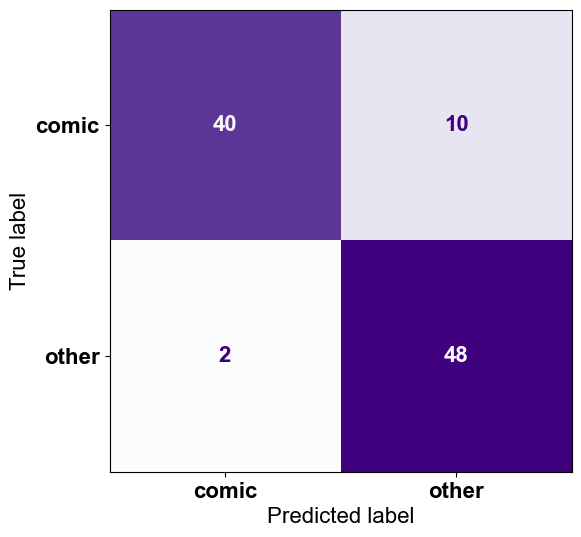

              precision    recall  f1-score   support

       comic       0.95      0.80      0.87        50
       other       0.83      0.96      0.89        50

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100



In [32]:
model_4o = "gemini-15-pro"
model_4o_res_dir = os.path.join(cf.response_dir, f"gemini/{model_4o}")
res_4o = eval_res(model_4o_res_dir, model_4o)
print(res_4o["cr"])

In [9]:
len(res_4o["sys_res"])

100

lensys 100 lenref 100


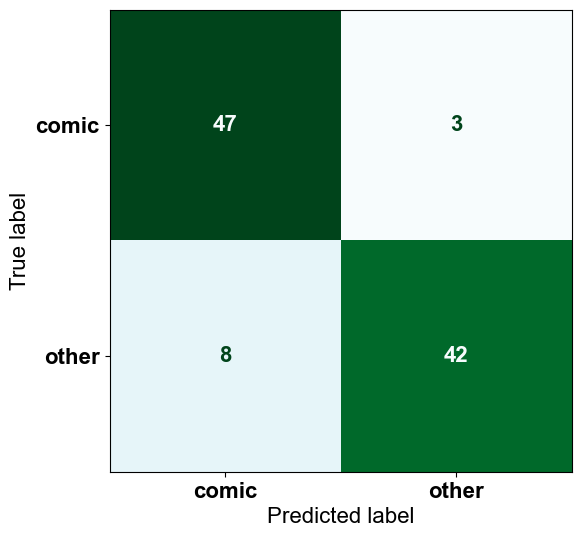

              precision    recall  f1-score   support

       comic       0.85      0.94      0.90        50
       other       0.93      0.84      0.88        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



In [22]:
from importlib import reload
reload(ut)
model_35 = "gemini-20-flash"
model_35_res_dir = os.path.join(cf.response_dir, f"gemini/{model_35}")
res_35 = eval_res(model_35_res_dir, model_35)
print(res_35["cr"])

### Look at errors

In [9]:
def get_error_case_idx_and_metadata(res, md_df):
  """
  Get the indices of the bad results and metadata like author or century.
  Args:
    res (dict): The results to get error cases for; `dict` format produced by `eval_res()`.
    md_df (DataFrame): Dataframe with metadata.

  Returns:
    tuple: Lists with the indices of the bad results, the centuries of the bad results, and the authors of the bad results.
  """
  bad_centuries = []
  bad_authors = []
  bad_idx = []
  print("\t".join(str(x) for x in ("idx", "rr", "sr", "century", "author", "title"))) 
  for idx, (sr, rr) in enumerate(zip(res["sys_res"], res["ref_res"])):
    if rr != sr:
      century = md_df.loc[md_df['id'] == idx + 1, 'centuryBirth'].iat[0]
      author = md_df.loc[md_df['id'] == idx + 1, 'author'].iat[0]
      title = md_df.loc[md_df['id'] == idx + 1, 'title'].iat[0]
      bad_centuries.append(century)
      bad_authors.append(author)
      bad_idx.append(idx + 1)
      print("\t".join(str(x) for x in (idx+1, rr, sr, century, author, title)))
  return bad_idx, bad_centuries, bad_authors

In [23]:
bad_idx, bad_centuries, bad_authors = get_error_case_idx_and_metadata(res_35, md_df)

idx	rr	sr	century	author	title
3	comic	other	20	Jon Juaristi	Patria mía
28	other	comic	19	Emilio Mora	Tempestades
37	other	comic	19	Arturo Reyes	Soneto
42	other	comic	19	Julio Herrera y Reissig	El granjero
50	other	comic	19	Rubén Darío	SONETO AUTUMNAL AL MARQUÉS DE BRADOMÍN
54	comic	other	19	Manuel del Palacio	El mayor dolor
60	comic	other	19	Manuel del Palacio	Trabajo perdido
78	other	comic	19	Manuel Bernabé	A LAONG - LAAN
80	other	comic	17	Francisco de Sigüenza	Soneto
89	other	comic	16	Luis Martín de la Plaza	Soneto
94	other	comic	19	Manuel Reina	La perla


In [24]:
Counter(bad_centuries)

Counter({19: 8, 20: 1, 17: 1, 16: 1})

In [25]:
Counter(bad_authors)

Counter({'Manuel del Palacio': 2,
         'Jon Juaristi': 1,
         'Emilio Mora': 1,
         'Arturo Reyes': 1,
         'Julio Herrera y Reissig': 1,
         'Rubén Darío': 1,
         'Manuel Bernabé': 1,
         'Francisco de Sigüenza': 1,
         'Luis Martín de la Plaza': 1,
         'Manuel Reina': 1})

In [13]:
def label_rewriter(label):
  """
  Should help only for labels in output directory;
  labels from evaluation function are already
  restricted to those allowed in `cf.orig_labels`
  """
  if label.lower() == "no":
    return "other"
  elif label.lower() in ("incierto", "incierta"):
    return "other-incierto"
  elif label.lower() == "sí":
    return "comic"
  else:
    return label.lower()

In [26]:
def analyze_results(res, model_res_dir, ana_dir, bad_idx, md_df, model_name):
  """
  Analyzes the results of a model.
  
  Args:
      res (dict): The results assigned to the variable (e.g., `res_35` or `res_4o`).
      model_res_dir (str): The directory where the model results are stored (e.g., `model_35_res_dir` or `model_4o_res_dir`).
      ana_dir (str): The directory where the analysis results will be stored.
      bad_idx (list): The indices of the bad results.
      md_df (DataFrame): The metadata DataFrame.
      model_name (str): The name of the model (e.g., `gpt-35-turbo` or `gpt-4o`).
  Returns:
    None
  """
  fname_for_bad_jmts = os.path.join(ana_dir, f"{model_name}_bads_all")
  fname_for_bad_jmts_fp = os.path.join(ana_dir, f"{model_name}_bads_fp")
  fname_for_bad_jmts_fn = os.path.join(ana_dir, f"{model_name}_bads_fn")
  bad_model_resps = [] #TODO why needed (if)?
  dones_for_pfx = {}
  poem_text = ""
  # open output files
  with open(fname_for_bad_jmts, mode="w") as oufi_all, \
      open(fname_for_bad_jmts_fp, mode="w") as oufi_fp, \
      open(fname_for_bad_jmts_fn, mode="w") as oufi_fn:
    for example_idx, bidx in enumerate(bad_idx):
      # get model responses for error cases
      model_resps_for_idx = sorted([fname for fname in sorted(os.listdir(model_res_dir))
                                    if fname.startswith("humor") and str.zfill(str(bidx), 4)
                                    in fname])
      #TODO This looks useless, why still here?
      bad_model_resps.extend(model_resps_for_idx[0:cf.max_choices_for_textometry])
      # iterate over error cases
      for mrfi in model_resps_for_idx[0:cf.max_choices_for_textometry]:
        mrfi_pfx = re.sub(r"_\d\..*$", "", mrfi)
        if mrfi_pfx not in dones_for_pfx:
          poem_text = ut.get_poem_text_by_id(bidx)
        # write out error info for analysis
        with open(os.path.join(model_res_dir, mrfi), mode="r") as respfi:
          author = md_df.loc[md_df['id'] == bidx, 'author'].iat[0]
          title = md_df.loc[md_df['id'] == bidx, 'title'].iat[0]
          century = md_df.loc[md_df['id'] == bidx, 'centuryBirth'].iat[0]
          txt = respfi.read()
          jso = json.loads(txt)
          if type(jso) is list:
              jso = jso[0]
          # jmt_from_outdir (directly from output dir) is to compare with eval result
          jmt_from_outdir, reason = jso["judgement"], jso["reason"]
          jmt_from_eval = res["sys_res"][bidx - 1]
          ref_res = res["ref_res"][bidx - 1]
          # keep track of how many for prefix to only output as many choices as analyzed in textometry
          dones_for_pfx.setdefault(mrfi_pfx, 1)
          dones_for_pfx[mrfi_pfx] += 1
          # makes outdir labels more homogeneous with labels output by eval
          jmt_from_outdir_rw = label_rewriter(jmt_from_outdir)
          jmt_from_eval_rw = label_rewriter(jmt_from_eval)
          ref_res_rw = label_rewriter(ref_res)
          # choose output file based on error type
          #   this is based on assumption that all results are errors
          #   and only the two errors below are possible
          assert jmt_from_eval_rw in ("comic", "other") and \
                 ref_res_rw in ("comic", "other") and \
                 jmt_from_eval_rw != ref_res_rw, f" MRFI: {mrfi} jmt_from_eval_rw: [{jmt_from_eval_rw}]; ref_res_rw: [{ref_res_rw}]"
          if jmt_from_eval_rw == "comic" and ref_res_rw == "other":
            oufi_partial = oufi_fp
          elif jmt_from_eval_rw == "other" and ref_res_rw == "comic":
            oufi_partial = oufi_fn
          # prepare output info
          md_for_ana = f" {author} ~ {title} ~ {century}"
          # total in len(bad_idx) no good for fp and fn total, not calculated
          logsep = "\n" + f"{'*' * 20} IDX [{bidx}] ({example_idx + 1}/{len(bad_idx)})" + md_for_ana + "\n\n" + poem_text + "\n" if \
          dones_for_pfx[mrfi_pfx] == cf.max_choices_for_textometry - 1 else ""
          for oufi in oufi_partial, oufi_all:
            oufi.write(
              f"\n{logsep}\nBad result for [{bidx}]\tSysRes Choice: [{jmt_from_outdir_rw}]; *SysRes Aggregated*: [{jmt_from_eval_rw}]; REFERENCE: [{ref_res_rw}]\n\t{reason}")

In [27]:
# analyze results for gemini-20-flash
analyze_results(res_35, model_35_res_dir, ana_dir, bad_idx, md_df, "gemini-20-flash")

In [35]:
# analyze results for gpt-4o
bad_idx4, bad_centuries4, bad_authors4 = get_error_case_idx_and_metadata(res_4o, md_df)
analyze_results(res_4o, model_4o_res_dir, ana_dir, bad_idx4, md_df, "gemini-15-pro")

idx	rr	sr	century	author	title
3	comic	other	20	Jon Juaristi	Patria mía
10	comic	other	19	Melchor Jufré del Águila	SONETO
11	comic	other	20	Jon Juaristi	A Vinogrado, avinagrado
23	comic	other	19	Miguel Ramos Carrión	El botijo
26	other	comic	16	Camila Lucinda	Al peregrino
53	comic	other	19	Manuel del Palacio	El amor ideal
54	comic	other	19	Manuel del Palacio	El mayor dolor
63	comic	other	19	Manuel del Palacio	A propósito de un bailarín
64	comic	other	19	Manuel del Palacio	Un amigo residente en Roma
67	comic	other	19	Manuel del Palacio	A un pobre rico
74	comic	other	16	Juan de Tassis y Peralta, Conde de Villamediana	A Jorge de Tovar
84	other	comic	19	Rosario («Crisantema») Sansores	La casada


## Author comparison

In [28]:
def analyze_author_info(model_res_dir, md_df):
  """
  Analyzes author information for a given model results directory.

  Args:
    model_res_dir (str): The directory where the model results are stored.
    md_df (DataFrame): The metadata DataFrame.

  Returns:
    None
  """
  ainfo = ut.get_author_info_for_dir(model_res_dir)
  au_matches = 0
  century_matches = 0
  century_diffs = []
  for ke, va in ainfo.items():
    poem_id = re.search(r"_(\d+)_", ke).group(1)
    assert poem_id is not None
    poem_id = int(poem_id)
    author_ref = md_df.loc[md_df['id'] == poem_id, 'author'].iat[0]
    century_ref = md_df.loc[md_df['id'] == poem_id, 'centuryBirth'].iat[0]
    au_match = 1 if va[0] == author_ref else 0
    century_match = 1 if va[1] == century_ref else 0
    au_matches += au_match
    century_matches += century_match
    century_diff = abs(va[1] - century_ref)
    century_diffs.append(century_diff)
    print(f"{ke.replace("author_", "")}\t{va[0]}\t{author_ref}\t{au_match}\t{va[1]}\t{century_ref}\t{century_match}\t{century_diff}")
  print(f"Total author matches: {au_matches} ({100*(au_matches/len(ainfo))}%)")
  print(f"Total century matches: {century_matches} ({100*(century_matches/len(ainfo))}%)")
  print(f"Mean century difference: {np.mean(century_diffs)} ({np.std(century_diffs)})")

  centuries_sys = [va[1] for va in ainfo.values()]
  centuries_ref = [md_df.loc[md_df['id'] == int(re.search(r"_(\d+)_", ke).group(1)), 'centuryBirth'].iat[0] for ke in ainfo.keys()]

  print("Pearson r", pearsonr(centuries_sys, centuries_ref))
  print("Spearman r", spearmanr(centuries_sys, centuries_ref))

In [29]:
reload(ut)
analyze_author_info(model_35_res_dir, md_df)

0001_gemini-20-flash.json	Rubén Darío	Augusto E. Madan	0	19	19	1	0
0002_gemini-20-flash.json	Luis de Góngora	Juan de Arguijo	0	17	19	0	2
0003_gemini-20-flash.json	Blas de Otero	Jon Juaristi	0	20	20	1	0
0004_gemini-20-flash.json	Francisco de Quevedo	Miguel de Cervantes	0	17	19	0	2
0005_gemini-20-flash.json	Desconocido	Augusto E. Madan	0	21	19	0	2
0006_gemini-20-flash.json	Francisco de Quevedo	Francisco de Quevedo	1	17	16	0	1
0007_gemini-20-flash.json	Francisco de Quevedo	Miguel de Cervantes	0	17	16	0	1
0008_gemini-20-flash.json	José Javier Alfaro	Jon Juaristi	0	20	20	1	0
0009_gemini-20-flash.json	José Asunción Silva	Manuel Bernabé	0	19	19	1	0
0010_gemini-20-flash.json	Sor Juana Inés de la Cruz	Melchor Jufré del Águila	0	17	19	0	2
0011_gemini-20-flash.json	Álvaro Cunqueiro	Jon Juaristi	0	20	20	1	0
0012_gemini-20-flash.json	Sor Juana Inés de la Cruz	Matías Frigola y Picón	0	17	17	1	0
0013_gemini-20-flash.json	José María Álvarez de Sotomayor y Flores	Blas Sirvent	0	20	19	0	1
0014_gemini-20

In [34]:
analyze_author_info(model_4o_res_dir, md_df)

0001_gemini-15-pro.json	José Juan Tablada	Augusto E. Madan	0	20	19	0	1
0002_gemini-15-pro.json	Anónimo	Juan de Arguijo	0	16	19	0	3
0003_gemini-15-pro.json	José María Gabriel y Galán	Jon Juaristi	0	19	20	0	1
0004_gemini-15-pro.json	Francisco de Quevedo	Miguel de Cervantes	0	17	19	0	2
0005_gemini-15-pro.json	Francisco Javier Vázquez Fernández	Augusto E. Madan	0	21	19	0	2
0006_gemini-15-pro.json	Francisco de Quevedo	Francisco de Quevedo	1	17	16	0	1
0007_gemini-15-pro.json	Lope de Vega	Miguel de Cervantes	0	17	16	0	1
0008_gemini-15-pro.json	Luis García Montero	Jon Juaristi	0	20	20	1	0
0009_gemini-15-pro.json	Ramón López Velarde	Manuel Bernabé	0	20	19	0	1
0010_gemini-15-pro.json	Francisco de Quevedo	Melchor Jufré del Águila	0	17	19	0	2
0011_gemini-15-pro.json	Felipe Benítez Reyes	Jon Juaristi	0	20	20	1	0
0012_gemini-15-pro.json	Sor Juana Inés de la Cruz	Matías Frigola y Picón	0	17	17	1	0
0013_gemini-15-pro.json	Francisco Villaespesa Martín	Blas Sirvent	0	19	19	1	0
0014_gemini-15-pro.json	Lu